In [1]:
import PIL.Image
import time

import numpy as np
import tensorflow as tf

from PIL import Image
import IPython.display as display
import matplotlib.pyplot as plt

CONTENT_IMG_PATH = "../slowpaper_dataset/K_image.jpg"
STYLE_IMG_PATH = "../slowpaper_dataset/style2.jpeg"
output_image_path = "./assets/output.jpg"

# 1. Data 

In [2]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
 
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

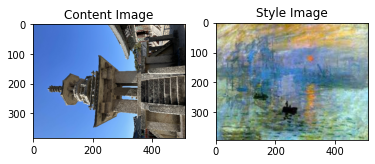

In [3]:
content_image = load_img(CONTENT_IMG_PATH)
style_image = load_img(STYLE_IMG_PATH)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [4]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# 2. Model
## 2.1. Load Pretrained Model

In [5]:
model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
for layer in model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


## 2.2. Build Model

In [6]:
# Select layers from the list
content_layers = ['block4_conv1']
style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2', 'block5_conv2']

In [7]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

def build_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

class MiddleModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(MiddleModel, self).__init__()
        self.vgg = build_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        
    def call(self, inputs):
        # Preprocessed numpy.array or a tf.Tensor with type float32
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        content_dict = {content_name: value for content_name, value 
                        in zip(self.content_layers, content_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

In [8]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) 
                           for name in style_outputs.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) 
                             for name in content_outputs.keys()])
    
    content_weight = 8
    style_weight = 1e4
 
    style_loss *= style_weight / num_style_layers
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    
    flattened_style_loss = tf.reduce_sum(style_loss)
    flattened_content_loss = tf.reduce_sum(content_loss)
  
    return loss 

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [9]:
extractor = MiddleModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# 3. Train Model

=============================  0: epoch =============================
10%

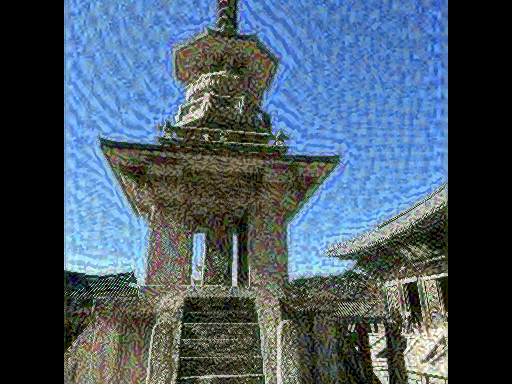

Train step: 10
=============================  1: epoch =============================
10%

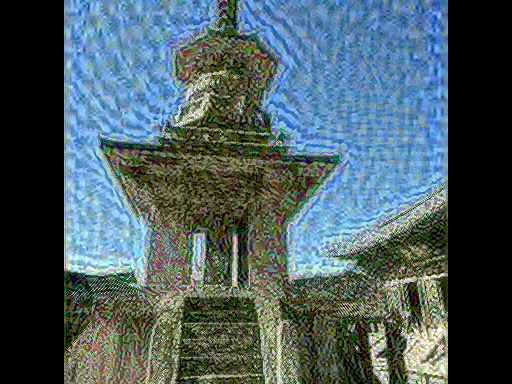

Train step: 20
=============================  2: epoch =============================
10%

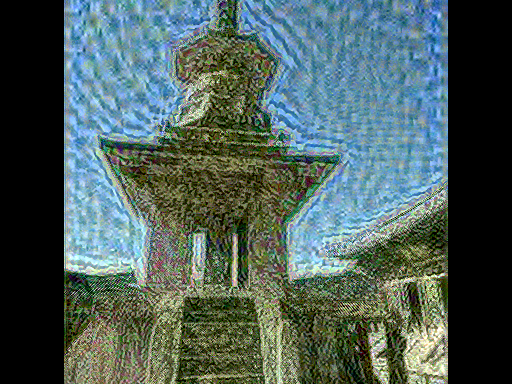

Train step: 30
=============================  3: epoch =============================
10%

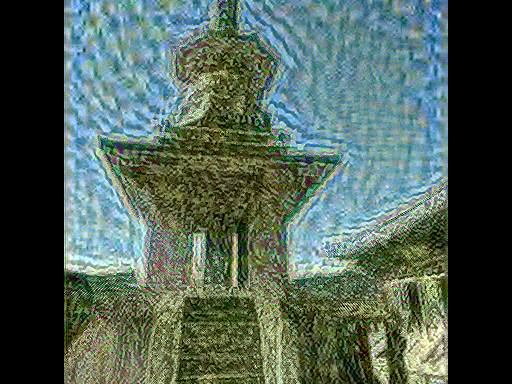

Train step: 40
=============================  4: epoch =============================
10%

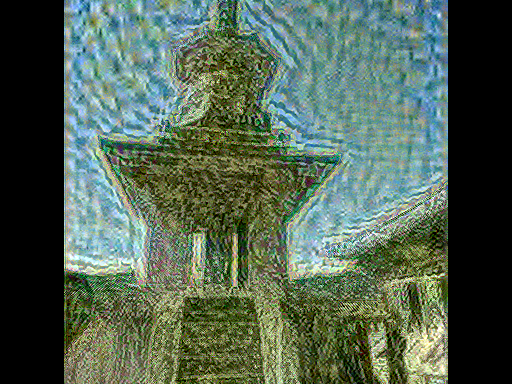

Train step: 50
=============================  5: epoch =============================
10%

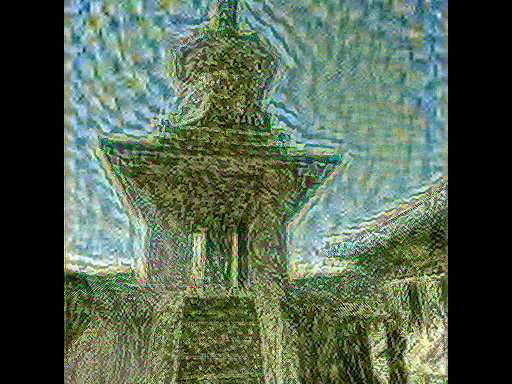

Train step: 60
=============================  6: epoch =============================
10%

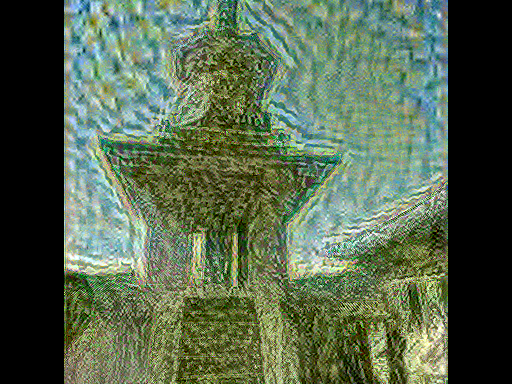

Train step: 70
=============================  7: epoch =============================
10%

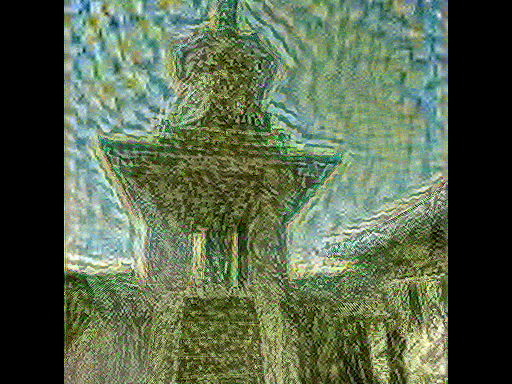

Train step: 80
=============================  8: epoch =============================
10%

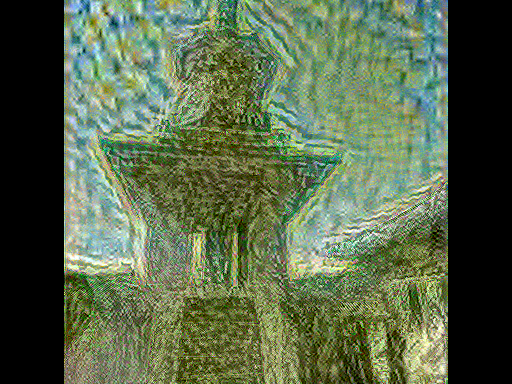

Train step: 90
=============================  9: epoch =============================
10%

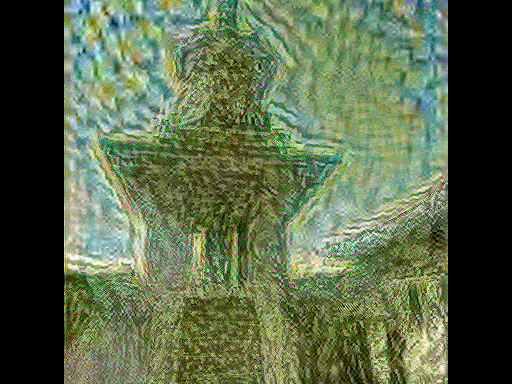

Train step: 100
Total time: 10.1


In [10]:
start = time.time()
epochs = 10
steps_per_epoch = 10
step = 0
image = tf.Variable(content_image)

for n in range(epochs):
    print(f"=============================  {n}: epoch =============================")
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(f"\r{m}%", end='', flush=True)

    display.display(tensor_to_image(image).rotate(-90))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))